In [2]:
import mat73
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import random
from PIL import Image
from torchvision import transforms
import torch

In [5]:
file_path = "../data/nyu_depth_v2_labeled.mat"
data_dict = mat73.loadmat(file_path)

ERROR:root:ERROR: MATLAB type not supported: containers.Map, (uint32)


In [6]:
class Depthset(Dataset):
    def __init__(self,data_dict,transform=None):
        self.data_dict = data_dict
        self.size = self.data_dict['images'].shape[-1]
        self.transform = transform

    def __len__(self):
        return self.size

    def __getitem__(self,idx):
        image = self.data_dict["images"][:,:,:,idx]
        depth = self.data_dict["depths"][:,:,idx]
        sample = {"image":image,"depth":depth}

        if self.transform:
            sample = self.transform(sample)

        return sample

class Agument(object):
    def __init__(self):
        pass

    def __call__(self,sample):
        image,depth = sample['image'], sample['depth']
        
        alt_method = random.randint(0,2)

        image = {
            0:image,
            1:np.fliplr(image),
            2:np.flipud(image)
        }[alt_method]
        
        depth = {
            0:depth,
            1:np.fliplr(depth),
            2:np.flipud(depth)
        }[alt_method]

        sample = {"image":image,"depth":depth}

        return sample

class toTensor(object):
    def __init__(self,downscale=4):
        self.downscale = downscale

    def __call__(self, sample):
        image, depth = sample['image'], sample['depth']
        image = self.to_tensor(image)

        depth = depth[::self.downscale, ::self.downscale]
        depth = self.to_tensor(depth) * 1000

        depth = torch.clamp(depth,10,1000)
        sample = {'image': image, 'depth': depth}

        return sample

    def to_tensor(self,img):
        if img.ndim == 2:
            img = img[...,np.newaxis]

        img = torch.from_numpy(np.ascontiguousarray(img.transpose((2, 0, 1))))

        return img.float().div(255)

In [7]:
depth_dataset = Depthset(data_dict=data_dict,
                transform=transforms.Compose([Agument(),toTensor()]))
train_loader=DataLoader(depth_dataset, 10, shuffle=True)

In [8]:
for batch in train_loader:
    print(batch)

{'image': tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]],


        [[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.]

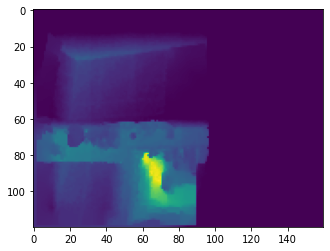

In [14]:
plt.imshow(batch['depth'][0,0])

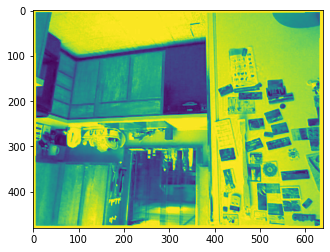

In [15]:
plt.imshow(batch['image'][0,0])